# BattMo Workshop

The workshop consists of the following parts:
- Hello BattMo: explore the basic features of BattMo.jl


 ---

Let's import BattMo and some other packages into the kernel.

In [1]:
using BattMo, GLMakie, Jutul, CSV, DataFrames
GLMakie.activate!(inline=true)

    CondaPkg Found dependencies: C:\Users\lorenah\.julia\packages\CondaPkg\0UqYV\CondaPkg.toml
    CondaPkg Found dependencies: C:\Users\lorenah\.julia\packages\PythonCall\mkWc2\CondaPkg.toml
    CondaPkg Initialising pixi
             │ C:\Users\lorenah\.julia\artifacts\aa881b8313f97d7b8797934574a1cfe551f85222\bin\pixi.exe
             │ init
             │ --format pixi
             └ c:\Users\lorenah\Documents\Repositories\BattMo-workshop-2025-10-20\.CondaPkg
Created C:\Users\lorenah\Documents\Repositories\BattMo-workshop-2025-10-20\.CondaPkg\pixi.toml
    CondaPkg Wrote c:\Users\lorenah\Documents\Repositories\BattMo-workshop-2025-10-20\.CondaPkg\pixi.toml
             │ [dependencies]
             │ openssl = ">=3, <3.6"
             │ 
             │     [dependencies.python]
             │     channel = "conda-forge"
             │     build = "*cp*"
             │     version = ">=3.9,<4"
             │ 
             │ [project]
             │ name = ".CondaPkg"
             │ p

## Part 1 - Hello BattMo

Welcome to this hands-on tutorial where we’ll explore the basics of BattMo.jl — a powerful Julia package for simulating lithium-ion battery cells using physics-based models like the Doyle-Fuller-Newman (DFN) model. 

By the end of this tutorial, you’ll:

- Understand some basic features of BattMo.jl
- Run your first battery simulation
- Explore and visualize the output
- Learn how to tweak key parameters for custom behavior




### a) Input ([docs](https://battmoteam.github.io/BattMo.jl/dev/manuals/user_guide/terminology))

BattMo.jl structures its simulation inputs into two primary categories: Parameters and Settings. This distinction helps users differentiate between the physical characteristics of the battery system and the numerical configurations of the simulation.

**Parameters** represent the controllable variables in real-world experiments. They are further divided into:

- **Cell Parameters**: define the intrinsic properties of the battery cell, such as geometry and material characteristics.
- **Cycling Protocol Parameters**: specify how the cell is operated during a simulation.

**Settings** are used to configure numerical assumptions for solving equations and finding numerical solutions. They are further divided into:

- **Model Settings**: define numerical assumptions related to the battery model, such as diffusion methods or simplifications used in the simulation.
- **Simulation Settings**: define numerical assumptions specific to the simulation process, including time-stepping schemes and discretization precision.
- **Solver Settings**: define solver behavior and verbosity.

**BattMo** stores cell parameters, cycling protocols and settings in a user-friendly JSON format to facilitate reuse. We can load the parameters directly from the default sets which can be very convenient for a quick parameter loading to test a simulation setup. In order to quickly see which default sets BattMo provides we can use the following function to print information about the sets available.

In [32]:
print_default_input_sets()


📋 Overview of Available Default Sets

📁 cell_parameters:         chayambuka_2022, chen_2020, xu_2015
📁 cycling_protocols:       cc_charge, cc_cycling, cc_discharge, cccv, user_defined_current_function
📁 full_simulation_input:   chen_2020, chen_2020_p4d
📁 model_settings:          p2d, p4d_cylindrical, p4d_pouch
📁 simulation_settings:     p2d, p2d_fine_resolution, p4d_cylindrical, p4d_pouch
📁 solver_settings:         default, direct, iterative

📖 Detailed Descriptions

📂 cell_parameters
----------------------------------------------------------------------------------------------------
chayambuka_2022
🔹 Cell name:       	-
🔹 Cell case:       	 
🔹 Source:          	[visit]((Invalid metadata format))

🔹 Suitable for:
   • RampUp:             Sinusoidal
   • TransportInSolid:   FullDiffusion
   • ModelFramework:     P2D
🔹 Description:     	Parameter set for a Sodium ion cell based on Chayambuka et al. The positive electrode open circuit potential has been retrieved from a [COMSOL example](

For our example, we load the cell parameter set from a NMC811 vs Graphite-SiOx cell whose parameters were determined in the [Chen 2020 paper](https://doi.org/10.1149/1945-7111/ab9050). We also load an example cycling protocol for a simple Constant Current Discharge. We can load them directly from the build in sets.

In [33]:
cell_parameters = load_cell_parameters(; from_default_set = "chen_2020");
cycling_protocol = load_cycling_protocol(; from_default_set = "cc_discharge");

This a quick way of testing a setup, but for the purpose of this workshop we would like to be able to see what a parameter set contains. Therefore, we'll retrieve the default parameter sets that BattMo provides and store them locally in a folder. We can do this by running the following script.

In [36]:
path = "."
folder_name = "default_sets"
generate_default_parameter_files(path, folder_name; force = true)

🛠 JSON files successfully written! Path:
	.\default_sets


".\\default_sets"

As we stored the default sets in our own folder, we can alter the default files if we want to and load the parameters from our dedicated folder.

In [37]:
cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/chen_2020.json");
cycling_protocol = load_cycling_protocol(; from_file_path = "default_sets/cycling_protocols/cc_discharge.json");

To change cell parameters, we can modify the JSON files directly, or we can read them into objects in the script and modify them as Dictionaries. A loaded cell parameter set is a Dictionary-like object which come with additional handy functions. First, lets list the outermost keys of the cell parameters object.

In [38]:
cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/chen_2020.json")
keys(cell_parameters)

KeySet for a Dict{String, Any} with 6 entries. Keys:
  "Electrolyte"
  "Cell"
  "Metadata"
  "PositiveElectrode"
  "Separator"
  "NegativeElectrode"

Now we access the Separator key.

In [39]:
cell_parameters["Separator"]

Dict{String, Any} with 5 entries:
  "Description"          => "Ceramic-coated Polyolefin"
  "Density"              => 946
  "BruggemanCoefficient" => 1.5
  "Thickness"            => 1.2e-5
  "Porosity"             => 0.47

We have a flat list of parameters and values for the separator. In other cases, a key might nest other dictionaries, which can be accessed using the normal dictionary notation. Lets for instance see the active material parameters of the negative electrode.

In [40]:
cell_parameters["NegativeElectrode"]["ActiveMaterial"]

Dict{String, Any} with 16 entries:
  "ActivationEnergyOfDiffusion"       => 5000
  "NumberOfElectronsTransfered"       => 1
  "StoichiometricCoefficientAtSOC0"   => 0.0279
  "OpenCircuitPotential"              => "1.9793 * exp(-39.3631*(c/cmax)) + 0.2…
  "ReactionRateConstant"              => 6.716e-12
  "MassFraction"                      => 1.0
  "StoichiometricCoefficientAtSOC100" => 0.9014
  "ActivationEnergyOfReaction"        => 35000
  "MaximumConcentration"              => 33133.0
  "VolumetricSurfaceArea"             => 383959.0
  "Description"                       => "Graphite-SiOx"
  "DiffusionCoefficient"              => 3.3e-14
  "ParticleRadius"                    => 5.86e-6
  "Density"                           => 2260.0
  "ElectronicConductivity"            => 215
  "ChargeTransferCoefficient"         => 0.5

There are many parameters, nested into dictionaries. Often, we are more interested in a specific subset of parameters. We can find a parameter with the search_parameter function. For example, we'd like to now how area related parameters are named:

In [41]:
search_parameter(cell_parameters, "area")


Parameters
------------------
[ "NegativeElectrode" ][ "ActiveMaterial" ][ "VolumetricSurfaceArea" ] => 383959.0
[ "PositiveElectrode" ][ "ActiveMaterial" ][ "VolumetricSurfaceArea" ] => 383959.0
[ "Cell" ][ "ElectrodeGeometricSurfaceArea" ] => 0.1027


Another way to view our parameters is by printing info about the parameter set.

In [42]:
print_info(cell_parameters)


PARAMETER OVERVIEW
Parameter                                                                                 Unit                Type                Value                         
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[ "Cell" ][ "Case" ]                                                                      N/A                 String              Cylindrical                   
[ "Cell" ][ "ElectrodeGeometricSurfaceArea" ]                                             m²                  Float64             0.1027                        
[ "Cell" ][ "Height" ]                                                                    m                   Float64             0.065                         
[ "Cell" ][ "InnerRadius" ]                                                               m                   Float64             0.002                         
[ "Cell" ][ "N

Parameters that take single numerical values (e.g. real, integers, booleans) can be directly modified.

In [43]:
cell_parameters["PositiveElectrode"]["Coating"]["Thickness"] = 8.2e-5

8.2e-5

Some parameters are described as functions or arrays, since the parameter value depends on other variables. For instance the Open Circuit Potentials of the Active Materials depend on the lithium stoichiometry and temperature. When we're unsure about the type or meaning of a parameter, we can print information on invidual parameters as well. For some parameters, that require more explanation, a link to the documentation is provided. Visit the documentation of the OpenCircuitPotential parameter to find more information on how to implement you own user defined functional parameters.

In [44]:
parameter_name = "OpenCircuitPotential"

print_info(parameter_name, view = "CellParameters")


----------------------------------------------------------------------------------------------------
🔋  Cell Parameter:  OpenCircuitPotential
----------------------------------------------------------------------------------------------------
    🔹 Name               OpenCircuitPotential
    🔹 Category           CellParameters
    🔹 Description        The open-circuit potential of the active material under a given intercalant stoichimetry and temperature.
    🔹 Type               String, Dict{String, Vector}, Real
    🔹 Unit               V
    🔹 Documentation      [visit](https://battmoteam.github.io/BattMo.jl/dev/manuals/user_guide/simulation_dependent_input)

    🔹 Ontology link      [visit](https://w3id.org/emmo/domain/electrochemistry#electrochemistry_9c657fdc_b9d3_4964_907c_f9a6e8c5f52b)




We can do a quick cell check to see if our cell parameter set makes sense. This function calculates equilibrium cell kpis.

In [30]:
quick_cell_check(cell_parameters)

════════════════════════════════════════════════════════════════════════════════════════════════════════════
🔋 Quick Cell Check
════════════════════════════════════════════════════════════════════════════════════════════════════════════

Quantity                                Chen2020       | Unit         | Source
────────────────────────────────────────────────────────────────────────────────────────────────────────────
Nominal Voltage                         3.71           | V            | [INPUT]     
Nominal Capacity                        4.8            | Ah           | [INPUT]     
Cell Theoretical Capacity               5.09           | Ah           | [EQUILIBRIUM CALCULATION]
Cell N:P Ratio                          0.8418         | -            | [EQUILIBRIUM CALCULATION]
Cell Mass                               0.04988        | kg           | [EQUILIBRIUM CALCULATION]
Positive Electrode Mass Loading         26.99          | mg/cm²       | [EQUILIBRIUM CALCULATION]
Negative Ele

The cycling protocol parameters and the settings (model settings, simulation settings, solver settings) can be loaded, viewed and altered in the same way as the cell parameters. Let's load a default CCCV cycling protocol. The settings we'll go into later.

In [31]:
cycling_protocol = load_cycling_protocol(; from_file_path= "default_sets/cycling_protocols/cccv.json");
print_info(cycling_protocol)


PARAMETER OVERVIEW
Parameter                                                                                 Unit                Type                Value                         
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[ "CRate" ]                                                                               1                   Float64             1.0                           
[ "CurrentChangeLimit" ]                                                                  A·s⁻¹               Float64             0.0001                        
[ "DRate" ]                                                                               1                   Float64             1.0                           
[ "InitialControl" ]                                                                      N/A                 String              charging                      
[ "InitialStat

### b) Run a simulation ([docs](https://battmoteam.github.io/BattMo.jl/dev/manuals/user_guide/public_api))

In this part we'll show how you can run a simple P2D simulation. Let's start by loading the Chen 2020 cell parameter set and a constant current discharge cycling protocol.

In [45]:
cell_parameters = load_cell_parameters(; from_default_set = "chen_2020");
cycling_protocol = load_cycling_protocol(; from_default_set = "cc_discharge");

Next, we select the default Lithium-Ion Battery model. A model can be thought as a mathematical implementation of the electrochemical and transport phenomena occuring in a real battery cell. The implementation consist of a system of partial differential equations and their corresponding parameters, constants and boundary conditions. The default Lithium-Ion Battery setup selected below contains the model settings to simulate a basic P2D model, where neither current collectors nor SEI growth are considered.

In [46]:
model = LithiumIonBattery();

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────


The LithiumIonBattery constructor validates the model settings on the back ground. If the model setup is valid we can continue and create a Simulation object by passing the model setup, cell parameters and a cycling protocol.

In [48]:
sim = Simulation(model, cell_parameters, cycling_protocol);

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────


The simulation object is only instantiated when the model provided is valid. We can see that the Simulation object also validates the parameters and settings on the back ground. Each parameter set is validated on whether they are sensible and complete. 

When the Simulation object is valid we can solve the simulation by passing the object to the solve function. As Julia is a compiled language, the first time that we run a simulation it will take some time to compile the functions and structs that it encounters. This makes running a second simulation very fast. See the difference by running the script for a second time.

In [49]:
output = solve(sim);

✔️ Validation of SolverSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress   1%|█                                          |  ETA: 0:14:58

Progress  42%|███████████████████                        |  ETA: 0:00:16

Progress  54%|████████████████████████                   |  ETA: 0:00:10

Progress  63%|████████████████████████████               |  ETA: 0:00:07

Progress  73%|████████████████████████████████           |  ETA: 0:00:05

Progress  80%|███████████████████████████████████        |  ETA: 0:00:03

Progress  87%|██████████████████████████████████████     |  ETA: 0:00:02

Progress 100%|███████████████████████████████████████████| Time: 0:00:13


╭────────────────┬───────────┬───────────────┬──────────╮
│ Iteration type │  Avg/step │  Avg/ministep │    Total │
│                │ 146 steps │ 146 ministeps │ (wasted) │
├────────────────┼───────────┼───────────────┼──────────┤
│ Newton         │   2.32192 │       2.32192 │  339 (0) │
│ Linearization  │   3.32192 │       3.32192 │  485 (0) │
│ Linear solver  │   2.32192 │       2.32192 │  339 (0) │
│ Precond apply  │       0.0 │           0.0 │    0 (0) │
╰────────────────┴───────────┴───────────────┴──────────╯
╭───────────────┬─────────┬────────────┬─────────╮
│ Timing type   │    Each │   Relative │   Total │
│               │      ms │ Percentage │       s │
├───────────────┼─────────┼────────────┼─────────┤
│ Properties    │  0.6816 │     1.94 % │  0.2311 │
│ Equations     │  6.2365 │    25.33 % │  3.0247 │
│ Assembly      │  2.7582 │    11.20 % │  1.3377 │
│ Linear solve  │  1.0058 │     2.86 % │  0.3410 │
│ Linear setup  │  0.0000 │     0.00 % │  0.0000 │
│ Precond apply │  

We can use some built in functions for quick plotting. The dashboard gives you a quick overview of some important ouput variables. You can choose to have interactive line plots where you can change the time step using a slider or contour plots that show the position and time in one plot.

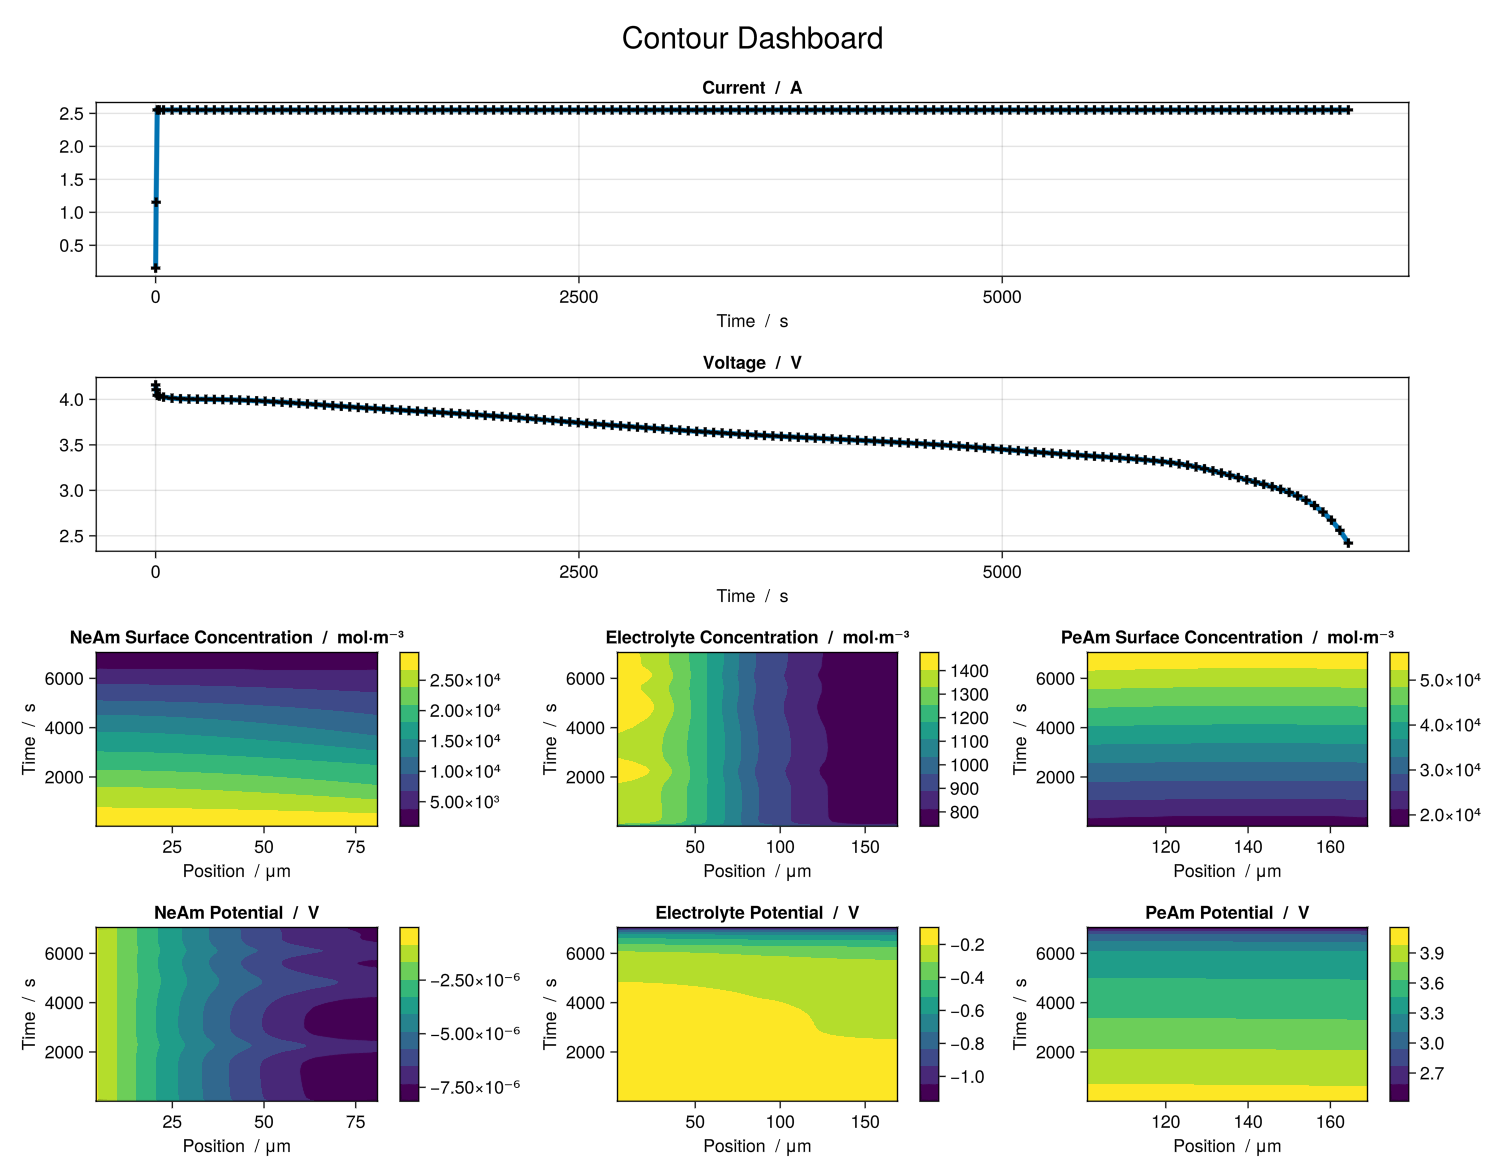

In [50]:
plot_dashboard(output; plot_type="contour")

As the line plot is an interactive plot and notebooks are not able to render interactive plots, we'll show it in a separate window. 

In [51]:
GLMakie.activate!(inline=false)

plot_dashboard(output; plot_type="line")

### c) Output ([docs](https://battmoteam.github.io/BattMo.jl/dev/tutorials/3_handle_outputs))

In BattMo.jl the output variables are divided into three different categories:
- **time series**: all variables that depent on time.
- **states**: all the state variables, which can be dependent on time, axial position and radial position.
- **metrics**: the calculated cell metrics, dependent on the cycle index.

In order to investigate how to retrieve output quantities, let's simulate a couple of constant current constant voltage cycles.

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SolverSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 days, 2 hours as 3600 report steps


Progress   0%|█                                          |  ETA: 0:09:27

Progress   0%|█                                          |  ETA: 0:02:50

Progress   0%|█                                          |  ETA: 0:02:08

Progress   1%|█                                          |  ETA: 0:01:55

Progress   1%|█                                          |  ETA: 0:01:56

Progress   1%|█                                          |  ETA: 0:01:50

Progress   1%|█                                          |  ETA: 0:02:07

Progress   1%|█                                          |  ETA: 0:01:56

Progress   2%|█                                          |  ETA: 0:01:48

Progress   2%|█                                          |  ETA: 0:01:37

Progress   2%|██                                         |  ETA: 0:01:28

Progress   3%|██                                         |  ETA: 0:01:24

Progress   3%|██                                         |  ETA: 0:01:23

Progress   3%|██                      

╭────────────────┬────────────┬────────────────┬─────────────╮
│ Iteration type │   Avg/step │   Avg/ministep │       Total │
│                │ 2599 steps │ 2717 ministeps │    (wasted) │
├────────────────┼────────────┼────────────────┼─────────────┤
│ Newton         │    2.73451 │        2.61575 │ 7107 (1620) │
│ Linearization  │    3.77992 │        3.61575 │ 9824 (1701) │
│ Linear solver  │    2.73451 │        2.61575 │ 7107 (1620) │
│ Precond apply  │        0.0 │            0.0 │       0 (0) │
╰────────────────┴────────────┴────────────────┴─────────────╯
╭───────────────┬────────┬────────────┬─────────╮
│ Timing type   │   Each │   Relative │   Total │
│               │     ms │ Percentage │       s │
├───────────────┼────────┼────────────┼─────────┤
│ Properties    │ 0.1722 │     3.09 % │  1.2240 │
│ Equations     │ 1.7637 │    43.77 % │ 17.3266 │
│ Assembly      │ 0.2940 │     7.30 % │  2.8883 │
│ Linear solve  │ 1.7549 │    31.51 % │ 12.4720 │
│ Linear setup  │ 0.0000 │     0.

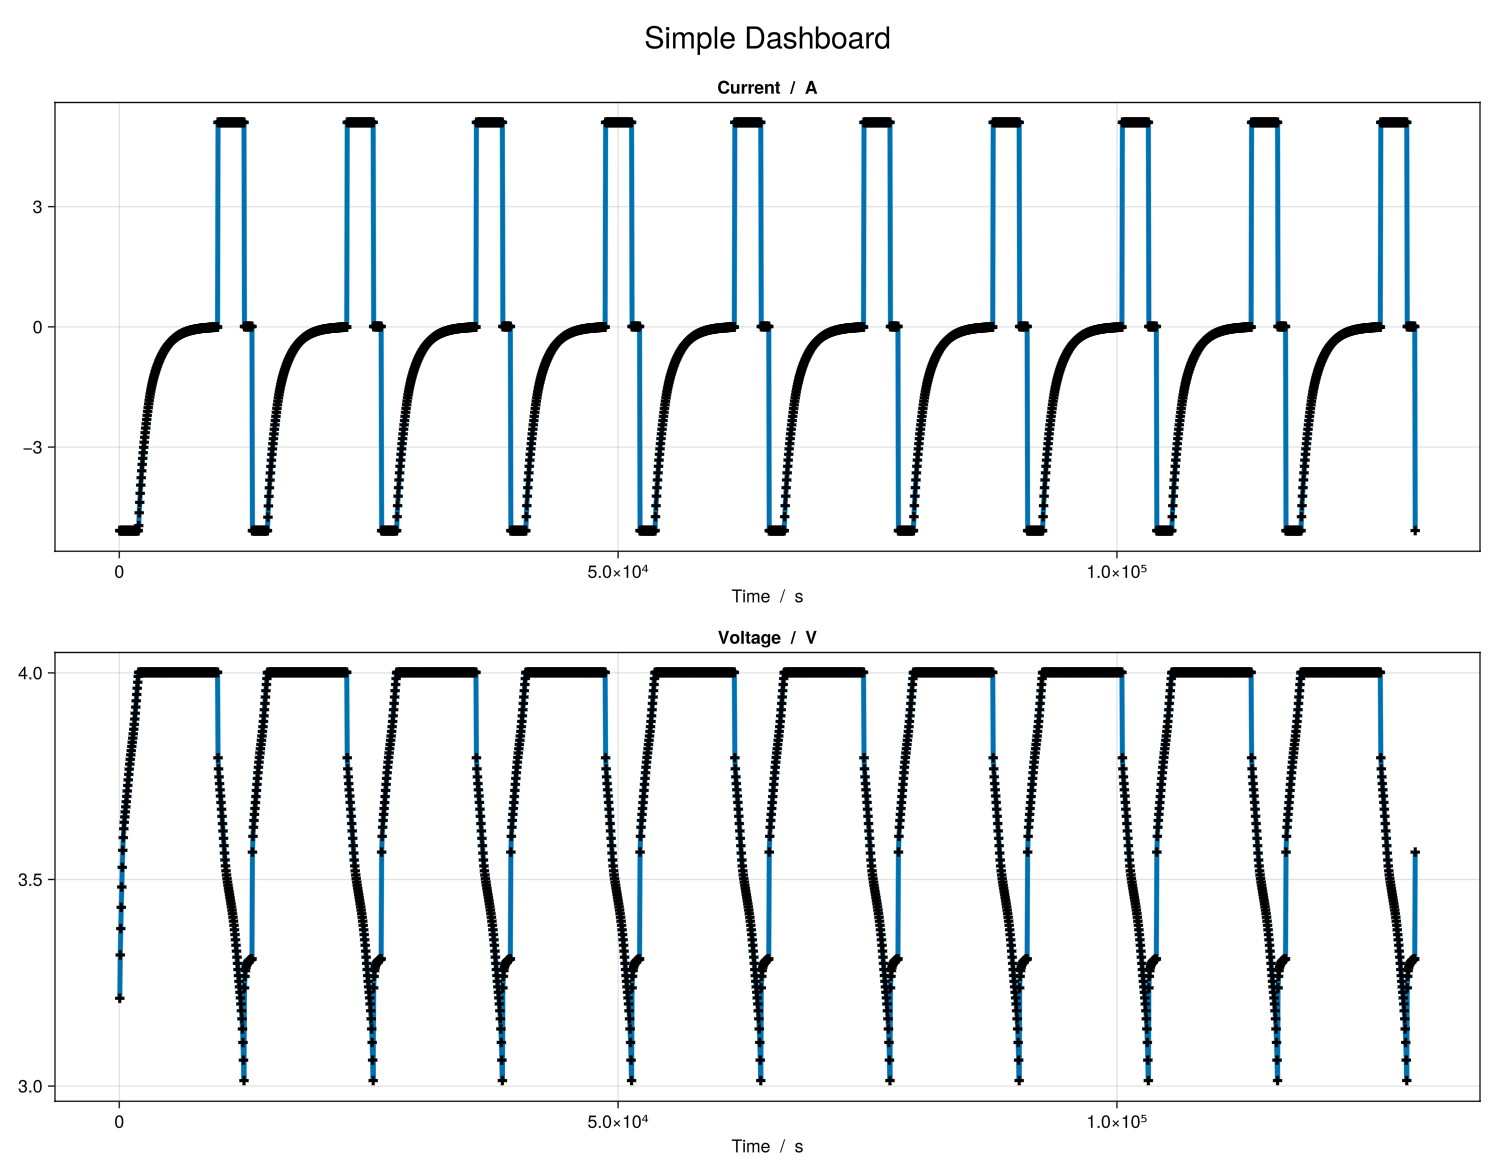

In [61]:
cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/chen_2020.json")
cycling_protocol = load_cycling_protocol(; from_file_path = "default_sets/cycling_protocols/cccv.json")

cycling_protocol["TotalNumberOfCycles"] = 10

model_setup = LithiumIonBattery()

sim = Simulation(model_setup, cell_parameters, cycling_protocol);

output = solve(sim);

GLMakie.activate!(inline=true)
plot_dashboard(output, plot_type = "simple")

Let's use the output from the previous CCCV simulation. We can again use the print info function to have a look into which output variables are available.

In [54]:
print_info(output)


Case: TIME_SERIES
Variable                                                         Unit                          Shape
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Capacity                                                         Ah                            (nTime,)
Current                                                          A                             (nTime,)
CycleNumber                                                      1                             (nTime,)
Time                                                             s                             (nTime,)
Voltage                                                          V                             (nTime,)

Case: METRICS
Variable                                                         Unit                          Shape
-----------------------------------------------------------------------------------

In the overview we can quickly see the aivalable variables and their units. We can also see that the variables have been devided into three categories like explained above: time series, states, and metrics. This has been done to provide some structure to the variables that is intuitive and cleans up the data. We also use these three categories when retrieving data. Let's first retrieve for example time series data like voltage, current and time.

In [55]:
time_series = output.time_series

t = time_series["Time"]
E = time_series["Voltage"]
I = time_series["Current"];

Let's now retrieve some state variables

In [56]:
states = output.states

electrolyte_concentration = states["ElectrolyteConcentration"]
electrolyte_potential = states["ElectrolytePotential"];

We can also print more information on each individual variable. For example, to look into the difference between the electrode particle concentration and surface concentration.

In [57]:
print_info("NegativeElectrodeActiveMaterialParticleConcentration")


----------------------------------------------------------------------------------------------------
📈  Output Variable:  NegativeElectrodeActiveMaterialParticleConcentration
----------------------------------------------------------------------------------------------------
    🔹 Name               NegativeElectrodeActiveMaterialParticleConcentration
    🔹 Category           OutputVariable
    🔹 Description        Radial distribution of lithium concentration in negative electrode particles.
    🔹 Type               Vector{Real}
    🔹 Shape              (nTime, nPosition, nNegativeElectrodeActiveMaterialRadius)
    🔹 Unit               mol·L⁻¹



In [58]:
print_info("NegativeElectrodeActiveMaterialSurfaceConcentration")


----------------------------------------------------------------------------------------------------
📈  Output Variable:  NegativeElectrodeActiveMaterialSurfaceConcentration
----------------------------------------------------------------------------------------------------
    🔹 Name               NegativeElectrodeActiveMaterialSurfaceConcentration
    🔹 Category           OutputVariable
    🔹 Description        Concentration of lithium ions at the surface of negative electrode particles.
    🔹 Type               Vector{Real}
    🔹 Shape              (nTime, nPosition)
    🔹 Unit               mol·L⁻¹



We can have a better idea of what the variable represents by reading the description and checking the shape of the variable. We can also retrieve some metrics from the output.

In [59]:
metrics = output.metrics

discharge_capacity = metrics["DischargeCapacity"]
round_trip_efficiency = metrics["RoundTripEfficiency"]
cycle_index = metrics["CycleIndex"]

10-element Vector{Int64}:
 0
 1
 2
 3
 4
 5
 6
 7
 8
 9

Let's plot the discharge capacity against its cycle index.

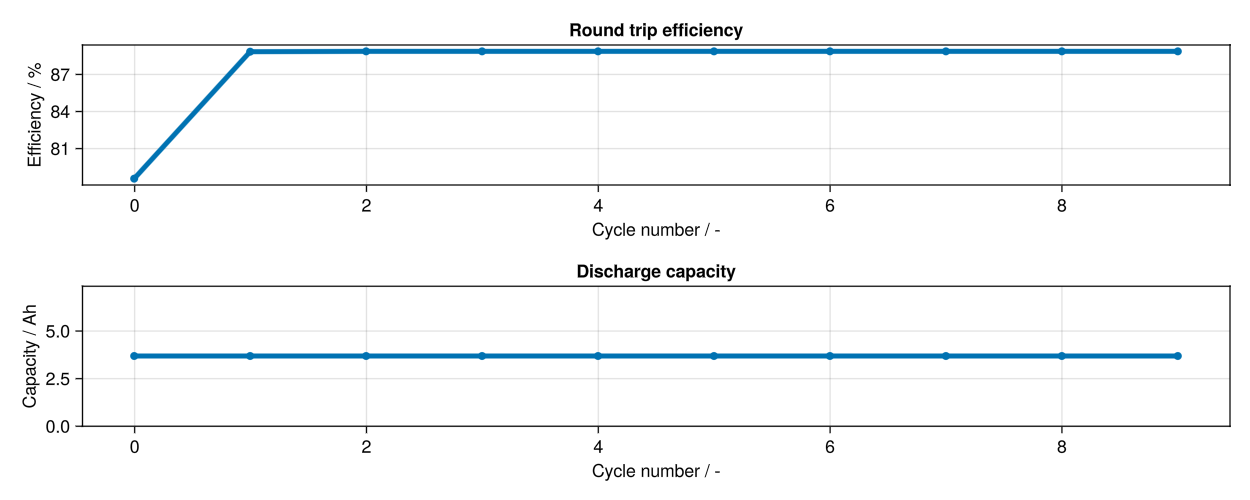

In [62]:

f = Figure(size = (1000, 400))

ax = Axis(f[1, 1], title = "Round trip efficiency", xlabel = "Cycle number / -", ylabel = "Efficiency / %",
)
scatterlines!(ax, cycle_index, round_trip_efficiency; linewidth = 4)

ax = Axis(f[2, 1], title = "Discharge capacity", xlabel = "Cycle number / -", ylabel = "Capacity / Ah",
)
scatterlines!(ax, cycle_index, discharge_capacity; linewidth = 4)

f